-------------------------------------------------------------------------------
Total epochs: 100 | Steps per epoch: 50 | Batch size: 32
-------------------------------------------------------------------------------
Dataset shape: (125973, 122)
-------------------------------------------------------------------------------
Epoch 0, Average Attack Accuracy: 16.53%

|Epoch 000/100| Time: 30.60|
|Def Reward: -966| Att Reward: 1359|
|Def Estimated: [387 321 268 301 323]| Att Labels: [433 495 211 355 106]
|Def Policy Loss: -0.0926| Def Value Loss: 20.2552| Def Grad Norm: 10.2495|
|Att Policy Loss: -0.0437| Att Value Loss: 46.5689| Att Grad Norm: 19.1828|
|Def Correct: [112  98  27  52  20] (['normal', 'DoS', 'Probe', 'R2L', 'U2R'])|
|Def Incorrect: [321 397 184 303  86] (['normal', 'DoS', 'Probe', 'R2L', 'U2R'])|
|Class Accuracies: normal: 25.9%, DoS: 19.8%, Probe: 12.8%, R2L: 14.6%, U2R: 18.9%|
|Def Entropy: 1.6041| Att Entropy: 3.6790|
Epoch 1, Average Attack Accuracy: 18.41%

|Epoch 001

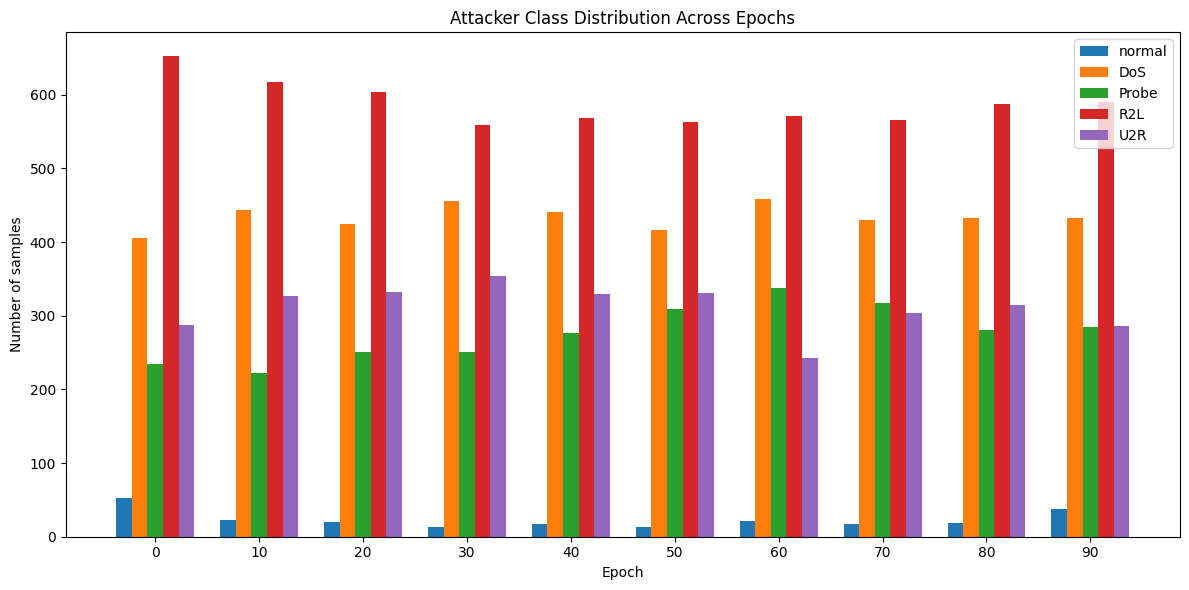

Training and visualization done. Proceed to evaluation/test as next step.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Input, Dense
from keras import optimizers
import tensorflow as tf
import os
import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score

# =================== DATA LOADER ===================
class data_cls:
    def __init__(self, train_test, **kwargs):
        col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
                     "dst_bytes", "land_f", "wrong_fragment", "urgent", "hot",
                     "num_failed_logins", "logged_in", "num_compromised", "root_shell",
                     "su_attempted", "num_root", "num_file_creations", "num_shells",
                     "num_access_files", "num_outbound_cmds", "is_host_login",
                     "is_guest_login", "count", "srv_count", "serror_rate",
                     "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                     "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
                     "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                     "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
                     "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
                     "dst_host_srv_rerror_rate", "labels", "dificulty"]
        self.train_test = train_test
        self.train_path = kwargs.get('train_path', 'KDDTrain+.txt')
        self.test_path = kwargs.get('test_path', 'KDDTest+.txt')
        self.formated_train_path = kwargs.get('formated_train_path', "formated_train_adv.data")
        self.formated_test_path = kwargs.get('formated_test_path', "formated_test_adv.data")

        self.attack_types = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
        self.attack_map = {
            'normal': 'normal', 'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS',
            'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
            'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe', 'mscan': 'Probe',
            'saint': 'Probe', 'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L',
            'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L',
            'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L',
            'worm': 'R2L', 'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
            'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'
        }
        self.all_attack_names = list(self.attack_map.keys())
        self.attack_names = []
        self._prepare_data(col_names)

    def _prepare_data(self, col_names):
        if os.path.exists(self.formated_train_path) and os.path.exists(self.formated_test_path):
            df_train = pd.read_csv(self.formated_train_path, sep=',')
            df_test = pd.read_csv(self.formated_test_path, sep=',')
        else:
            df_train = pd.read_csv(self.train_path, sep=',', names=col_names, index_col=False)
            df_test = pd.read_csv(self.test_path, sep=',', names=col_names, index_col=False)
            if 'dificulty' in df_train.columns:
                df_train.drop('dificulty', axis=1, inplace=True)
            if 'dificulty' in df_test.columns:
                df_test.drop('dificulty', axis=1, inplace=True)
            full_df = pd.concat([df_train, df_test], ignore_index=True)
            for cat in ['protocol_type', 'service', 'flag']:
                full_df = pd.concat([full_df.drop(cat, axis=1), pd.get_dummies(full_df[cat])], axis=1)
            if 'su_attempted' in full_df.columns:
                full_df['su_attempted'] = full_df['su_attempted'].replace(2.0, 0.0)
            full_df = pd.concat([full_df.drop('labels', axis=1), pd.get_dummies(full_df['labels'])], axis=1)
            for col, dtype in full_df.dtypes.items():
                if dtype in ['float64', 'int64']:
                    if full_df[col].max() != full_df[col].min():
                        full_df[col] = (full_df[col] - full_df[col].min()) / (full_df[col] - full_df[col].min())
                    else:
                        full_df[col] = 0
            df_train = full_df.iloc[:len(df_train)]
            df_test = full_df.iloc[len(df_train):]
            df_train.to_csv(self.formated_train_path, sep=',', index=False)
            df_test.to_csv(self.formated_test_path, sep=',', index=False)

        for att in self.attack_map:
            if ((att in df_train.columns and np.sum(df_train[att].values) > 1) or
                (att in df_test.columns and np.sum(df_test[att].values) > 1)):
                self.attack_names.append(att)

        feature_cols = [c for c in df_train.columns if c not in self.all_attack_names]
        label_cols = self.attack_names

        if self.train_test == 'train':
            self.X = df_train[feature_cols].values.astype(np.float32)
            self.y = df_train[label_cols].values.astype(np.float32)
        else:
            self.X = df_test[feature_cols].values.astype(np.float32)
            self.y = df_test[label_cols].values.astype(np.float32)

        idx = np.random.permutation(len(self.X))
        self.X, self.y = self.X[idx], self.y[idx]

    def get_shape(self):
        return self.X.shape

    def get_full(self):
        return self.X, self.y

# =================== NETWORKS ===================
class PolicyNetwork:
    def __init__(self, obs_size, num_actions, hidden_size=128, hidden_layers=1):
        self.model = Sequential()
        self.model.add(Input(shape=(obs_size,)))
        self.model.add(Dense(hidden_size, activation='relu'))
        for _ in range(hidden_layers):
            self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(num_actions, activation='softmax'))
        self.optimizer = optimizers.Adam(learning_rate=0.0001)

class ValueNetwork:
    def __init__(self, obs_size, hidden_size=128, hidden_layers=1):
        self.model = Sequential()
        self.model.add(Input(shape=(obs_size,)))
        self.model.add(Dense(hidden_size, activation='relu'))
        for _ in range(hidden_layers):
            self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.optimizer = optimizers.Adam(learning_rate=0.0001)

# =================== AGENTS ===================
class Agent:
    def __init__(self, actions, obs_size, **kwargs):
        self.actions = actions
        self.num_actions = len(actions)
        self.obs_size = obs_size
        self.gamma = kwargs.get('gamma', 0.99)
        self.lam = kwargs.get('lam', 0.95)
        self.clip_epsilon = kwargs.get('clip_epsilon', 0.1)
        self.policy_net = PolicyNetwork(obs_size, self.num_actions, kwargs.get('hidden_size', 128), kwargs.get('hidden_layers', 1))
        self.value_net = ValueNetwork(obs_size, kwargs.get('hidden_size', 128), kwargs.get('hidden_layers', 1))
        self.action_counts = np.zeros(self.num_actions)

    def act(self, states):
        if states.ndim == 1:
            states = states.reshape(1, -1)
        batch_size = states.shape[0]
        probs = self.policy_net.model(states, training=False).numpy()
        values = self.value_net.model(states, training=False).numpy().flatten()
        actions = np.array([np.random.choice(self.num_actions, p=probs[i]) for i in range(batch_size)])
        log_probs = np.array([np.log(probs[i, actions[i]] + 1e-8) for i in range(batch_size)])
        entropies = np.array([-np.sum(probs[i] * np.log(probs[i] + 1e-8)) for i in range(batch_size)])
        for a in actions:
            self.action_counts[a] += 1
        return actions, log_probs, values, entropies

    def compute_gae(self, rewards, values, next_value):
        rewards = np.vstack(rewards)
        values = np.vstack(values)
        next_value = np.array(next_value)
        batch_size = rewards.shape[1]
        advantages = np.zeros_like(rewards, dtype=np.float32)
        returns = np.zeros_like(rewards, dtype=np.float32)

        for b in range(batch_size):
            traj_rewards = rewards[:, b]
            traj_values = values[:, b]
            traj_next_value = next_value[b]
            traj_next_values = np.append(traj_values[1:], traj_next_value)
            deltas = traj_rewards + self.gamma * traj_next_values - traj_values
            adv = 0
            adv_list = []
            for delta in deltas[::-1]:
                adv = delta + self.gamma * self.lam * adv
                adv_list.insert(0, adv)
            traj_advantages = np.array(adv_list)
            traj_returns = traj_advantages + traj_values
            traj_advantages = (traj_advantages - np.mean(traj_advantages)) / (np.std(traj_advantages) + 1e-8)
            advantages[:, b] = traj_advantages
            returns[:, b] = traj_returns
        return advantages, returns

    # ...existing code...
    def ppo_update(self, states, actions, log_probs_old, advantages, returns, epochs=10, minibatch_size=32, entropy_coef=0.05):
        states = np.vstack(states)
        actions = np.hstack(actions)
        log_probs_old = np.hstack(log_probs_old)
        advantages = advantages.flatten()
        returns = returns.flatten()
        
        policy_losses, value_losses, grad_norms = [], [], []

        for _ in range(epochs):
            indices = np.random.permutation(len(states))
            for start in range(0, len(states), minibatch_size):
                batch_indices = indices[start:start + minibatch_size]
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_log_probs_old = log_probs_old[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                with tf.GradientTape() as tape:
                    probs = self.policy_net.model(batch_states, training=True)
                    log_probs_new = tf.math.log(tf.gather(probs, batch_actions, batch_dims=1) + 1e-8)
                    values_new = self.value_net.model(batch_states, training=True)
                    ratio = tf.exp(log_probs_new - batch_log_probs_old)
                    sur1 = ratio * batch_advantages
                    sur2 = tf.clip_by_value(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * batch_advantages
                    # Entropy bonus
                    entropy = -tf.reduce_mean(tf.reduce_sum(probs * tf.math.log(probs + 1e-8), axis=1))
                    policy_loss = -tf.reduce_mean(tf.minimum(sur1, sur2)) - entropy_coef * entropy
                    value_loss = tf.reduce_mean(tf.square(batch_returns - values_new))
                    loss = policy_loss + 0.5 * value_loss
                policy_losses.append(policy_loss.numpy())
                value_losses.append(value_loss.numpy())
                variables = self.policy_net.model.trainable_variables + self.value_net.model.trainable_variables
                grads = tape.gradient(loss, variables)
                grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads if g is not None]))
                grad_norms.append(grad_norm.numpy())
                self.policy_net.optimizer.apply_gradients(zip(grads[:len(self.policy_net.model.trainable_variables)], self.policy_net.model.trainable_variables))
                self.value_net.optimizer.apply_gradients(zip(grads[len(self.policy_net.model.trainable_variables):], self.value_net.model.trainable_variables))
        return np.mean(policy_losses), np.mean(value_losses), np.mean(grad_norms)

    def get_action_distribution(self):
        total = np.sum(self.action_counts)
        if total == 0:
            return np.zeros(self.num_actions)
        return self.action_counts / total

    def reset_action_counts(self):
        self.action_counts = np.zeros(self.num_actions)
        
    def save(self, prefix):
        self.policy_net.model.save(f"{prefix}_policy.keras")
        self.value_net.model.save(f"{prefix}_value.keras")

    def load(self, prefix):
        self.policy_net.model = load_model(f"{prefix}_policy.keras")
        self.value_net.model = load_model(f"{prefix}_value.keras")

# =================== RL ENVIRONMENT ===================
class RLenv(data_cls):
    def __init__(self, train_test, **kwargs):
        super().__init__(train_test, **kwargs)
        self.data_shape = self.get_shape()
        self.batch_size = kwargs.get('batch_size', 1)
        self.iterations_episode = kwargs.get('iterations_episode', 100)

    def reset(self):
        self.def_true_labels = np.zeros(len(self.attack_types), dtype=int)
        self.def_estimated_labels = np.zeros(len(self.attack_types), dtype=int)
        self.att_true_labels = np.zeros(len(self.attack_names), dtype=int)
        self.def_correct = np.zeros(len(self.attack_types), dtype=int)
        self.def_incorrect = np.zeros(len(self.attack_types), dtype=int)
        self.confusion_matrix = np.zeros((len(self.attack_types), len(self.attack_types)), dtype=int)
        idx = np.random.choice(len(self.X), self.batch_size, replace=False)
        self.states = self.X[idx]
        self.labels = self.y[idx]
        return self.states

    def act(self, defender_actions, attack_actions):
        self.def_reward = np.zeros(len(defender_actions))
        self.att_reward = np.zeros(len(attack_actions))
        for i in range(len(defender_actions)):
            def_action = defender_actions[i]
            true_attack = np.argmax(self.labels[i])
            true_class = self.attack_types.index(self.attack_map[self.attack_names[true_attack]])
            est_class = def_action
            attack_type_name = self.attack_types[true_class]

            # Update classification stats
            self.def_true_labels[true_class] += 1
            self.def_estimated_labels[est_class] += 1
            self.att_true_labels[attack_actions[i]] += 1
            self.confusion_matrix[true_class, est_class] += 1
            
            if est_class == true_class:
                self.def_correct[true_class] += 1
            else:
                self.def_incorrect[true_class] += 1

            # DEFENDER REWARD
            if def_action == true_class:
                if attack_type_name in ['U2R', 'R2L']:
                    self.def_reward[i] = 2.0  # rare attack correctly identified
                elif attack_type_name in ['DoS', 'Probe']:
                    self.def_reward[i] = 1.0  # common attack correctly identified
                else:
                    self.def_reward[i] = 0.5  # normal
            else:
                self.def_reward[i] = -1  # misclassification

            # ATTACKER REWARD
            if def_action != true_class:
                if attack_type_name in ['U2R', 'R2L']:
                    self.att_reward[i] = 2.0  # rare attack evaded detection
                elif attack_type_name in ['DoS', 'Probe']:
                    self.att_reward[i] = 1.0  # common attack evaded detection
                else:
                    self.att_reward[i] = 0  # 'normal' shouldn't be rewarded
            else:
                self.att_reward[i] = 0  # attacker failed

        return self.states, self.def_reward, self.att_reward, False

    def get_states(self, attacker_actions):
        idxs = []
        for att_action in attacker_actions:
            att_name = self.attack_names[att_action]  # Get name like 'neptune', 'normal', etc.
            att_idx = self.attack_names.index(att_name)
            # Find all indices where this attack is present in the one-hot label vector
            attack_indices = np.where(self.y[:, att_idx] == 1)[0]
            if len(attack_indices) > 0:
                sampled_idx = np.random.choice(attack_indices, size=1)[0]
                idxs.append(sampled_idx)
            else:
                # Fallback: sample a random index if no matching data found (should rarely happen)
                idxs.append(np.random.choice(len(self.X), size=1)[0])

        # Now batch is 1-to-1 matched to attacker actions
        idxs = np.array(idxs)
        minibatch = self.X[idxs]
        self.labels = self.y[idxs]
        self.states = minibatch
        return self.states


# =================== MAIN TRAINING LOOP ===================
if __name__ == "__main__":
    # ==== Paths ====
    kdd_train = "https://raw.githubusercontent.com/gcamfer/Anomaly-ReactionRL/master/datasets/NSL/KDDTrain%2B.txt"
    kdd_test = "https://raw.githubusercontent.com/gcamfer/Anomaly-ReactionRL/master/datasets/NSL/KDDTest%2B.txt"
    formated_train_path = "formated_train_adv.data"
    formated_test_path = "formated_test_adv.data"

    batch_size = 32
    iterations_episode = 50
    num_episodes = 100

    env = RLenv('train', train_path=kdd_train, test_path=kdd_test,
                formated_train_path=formated_train_path, formated_test_path=formated_test_path,
                batch_size=batch_size, iterations_episode=iterations_episode)
    obs_size = env.X.shape[1]

    defender_valid_actions = list(range(len(env.attack_types)))
    defender_num_actions = len(defender_valid_actions)
    defender_agent = Agent(defender_valid_actions, obs_size, gamma=0.99, hidden_size=128, hidden_layers=3)
    attack_valid_actions = list(range(len(env.attack_names)))
    attack_num_actions = len(attack_valid_actions)
    attacker_agent = Agent(attack_valid_actions, obs_size, gamma=0.99, hidden_size=128, hidden_layers=1)

    att_reward_chain, def_reward_chain = [], []
    def_loss_chain = []  # fill this during training with `def_value_loss` per epoch
    att_loss_chain = []  # fill this during training with `att_value_loss` per epoch

    attacks_by_epoch = []
    print("-------------------------------------------------------------------------------")
    print(f"Total epochs: {num_episodes} | Steps per epoch: {iterations_episode} | Batch size: {batch_size}")
    print("-------------------------------------------------------------------------------")
    print(f"Dataset shape: {env.data_shape}")
    print("-------------------------------------------------------------------------------")

    for epoch in range(num_episodes):
        def_total_reward, att_total_reward = 0, 0
        defender_agent.reset_action_counts()
        attacker_agent.reset_action_counts()

        states = env.reset()
        att_actions, att_log_probs, att_values, att_entropies = attacker_agent.act(states)
        states = env.get_states(att_actions)
        att_actions_this_epoch = [att_actions]

        states_list = [states]
        att_actions_list, att_log_probs_list, att_values_list, att_rewards_list = [att_actions], [att_log_probs], [att_values], []
        def_actions_list, def_log_probs_list, def_values_list, def_rewards_list = [], [], [], []

        epoch_def_entropies, epoch_att_entropies = [], []

        start_time = time.time()

        for t in range(iterations_episode):
            def_actions, def_log_probs, def_values, def_entropies = defender_agent.act(states)
            def_actions_list.append(def_actions)
            def_log_probs_list.append(def_log_probs)
            def_values_list.append(def_values)
            epoch_def_entropies.append(np.mean(def_entropies))

            next_states, def_rewards, att_rewards, _ = env.act(def_actions, att_actions)
            def_rewards_list.append(def_rewards)
            att_rewards_list.append(att_rewards)
            def_total_reward += np.sum(def_rewards)
            att_total_reward += np.sum(att_rewards)

            next_att_actions, next_att_log_probs, next_att_values, next_att_entropies = attacker_agent.act(states)
            att_actions_list.append(next_att_actions)
            att_log_probs_list.append(next_att_log_probs)
            att_values_list.append(next_att_values)
            att_actions_this_epoch.append(next_att_actions)
            epoch_att_entropies.append(np.mean(next_att_entropies))

            states = env.get_states(next_att_actions)
            states_list.append(states)
            att_actions = next_att_actions

        # PPO update
        att_next_value = attacker_agent.value_net.model.predict(states, verbose=0).flatten()
        att_advantages, att_returns = attacker_agent.compute_gae(att_rewards_list, att_values_list[:-1], att_next_value)
        def_next_value = defender_agent.value_net.model.predict(states, verbose=0).flatten()
        def_advantages, def_returns = defender_agent.compute_gae(def_rewards_list, def_values_list, def_next_value)

        att_policy_loss, att_value_loss, att_grad_norm = attacker_agent.ppo_update(
            states_list[:-1], att_actions_list[:-1], att_log_probs_list[:-1], att_advantages, att_returns, entropy_coef=0.01
        )
        def_policy_loss, def_value_loss, def_grad_norm = defender_agent.ppo_update(
            states_list[:-1], def_actions_list, def_log_probs_list, def_advantages, def_returns
        )

        def_reward_chain.append(def_total_reward)
        att_reward_chain.append(att_total_reward)
        def_loss_chain.append(def_value_loss)
        att_loss_chain.append(att_value_loss)

        attacks_by_epoch.append(np.vstack(att_actions_this_epoch))

        end_time = time.time()

        # Compute per-class accuracy
        class_accuracies = []
        for i, attack_type in enumerate(env.attack_types):
            total = env.def_correct[i] + env.def_incorrect[i]
            accuracy = (env.def_correct[i] / total * 100) if total > 0 else 0
            class_accuracies.append(accuracy)
        class_accuracies_str = [f"{attack_type}: {acc:.1f}%" for attack_type, acc in zip(env.attack_types, class_accuracies)]

        # Early stopping based on attack class accuracies (excluding normal)
        attack_accuracies = class_accuracies[1:]  # Exclude normal (index 0)
        avg_attack_accuracy = np.mean(attack_accuracies)
        print(f"Epoch {epoch}, Average Attack Accuracy: {avg_attack_accuracy:.2f}%")
        if avg_attack_accuracy > 98:  # Stop if average attack accuracy exceeds 90%
            print(f"Early stopping at epoch {epoch}: Average attack accuracy {avg_attack_accuracy:.2f}%")
            break

        print(
            f"\n|Epoch {epoch:03d}/{num_episodes:03d}| Time: {end_time - start_time:.2f}|"
            f"\n|Def Reward: {def_total_reward:03.0f}| Att Reward: {att_total_reward:03.0f}|"
            f"\n|Def Estimated: {np.array2string(env.def_estimated_labels, separator=' ')}| Att Labels: {np.array2string(env.def_true_labels, separator=' ')}"
            f"\n|Def Policy Loss: {def_policy_loss:.4f}| Def Value Loss: {def_value_loss:.4f}| Def Grad Norm: {def_grad_norm:.4f}|"
            f"\n|Att Policy Loss: {att_policy_loss:.4f}| Att Value Loss: {att_value_loss:.4f}| Att Grad Norm: {att_grad_norm:.4f}|"
            f"\n|Def Correct: {np.array2string(env.def_correct, separator=' ')} ({env.attack_types})|"
            f"\n|Def Incorrect: {np.array2string(env.def_incorrect, separator=' ')} ({env.attack_types})|"
            f"\n|Class Accuracies: {', '.join(class_accuracies_str)}|"
            f"\n|Def Entropy: {np.mean(epoch_def_entropies):.4f}| Att Entropy: {np.mean(epoch_att_entropies):.4f}|"
        )

    # ============== VISUALIZE ATTACKER CLASS DISTRIBUTION ==========
    epochs_to_plot = list(range(0, len(attacks_by_epoch), 10))
    class_names = env.attack_types
    attack_counts_per_epoch = []
    for e in epochs_to_plot:
        sample = attacks_by_epoch[e]
        sample_mapped = [env.attack_types.index(env.attack_map[env.attack_names[att]]) for att in sample.flatten()]
        counts = [sample_mapped.count(i) for i in range(len(class_names))]
        attack_counts_per_epoch.append(counts)
    attack_counts_per_epoch = np.array(attack_counts_per_epoch)
    bar_width = 0.15
    x = np.arange(len(epochs_to_plot))
    plt.figure(figsize=(12, 6))
    for i, cname in enumerate(class_names):
        plt.bar(x + i*bar_width, attack_counts_per_epoch[:, i], width=bar_width, label=cname)
    plt.xlabel("Epoch")
    plt.ylabel("Number of samples")
    plt.title("Attacker Class Distribution Across Epochs")
    plt.xticks(x + bar_width*2, epochs_to_plot)
    plt.legend()
    plt.tight_layout()
    os.makedirs('results', exist_ok=True)
    plt.savefig("results/attacker_distribution.png", dpi=300)
    plt.show()
    
    os.makedirs('models', exist_ok=True)
    defender_agent.save("models/defender")
    attacker_agent.save("models/attacker")

    print("Training and visualization done. Proceed to evaluation/test as next step.")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


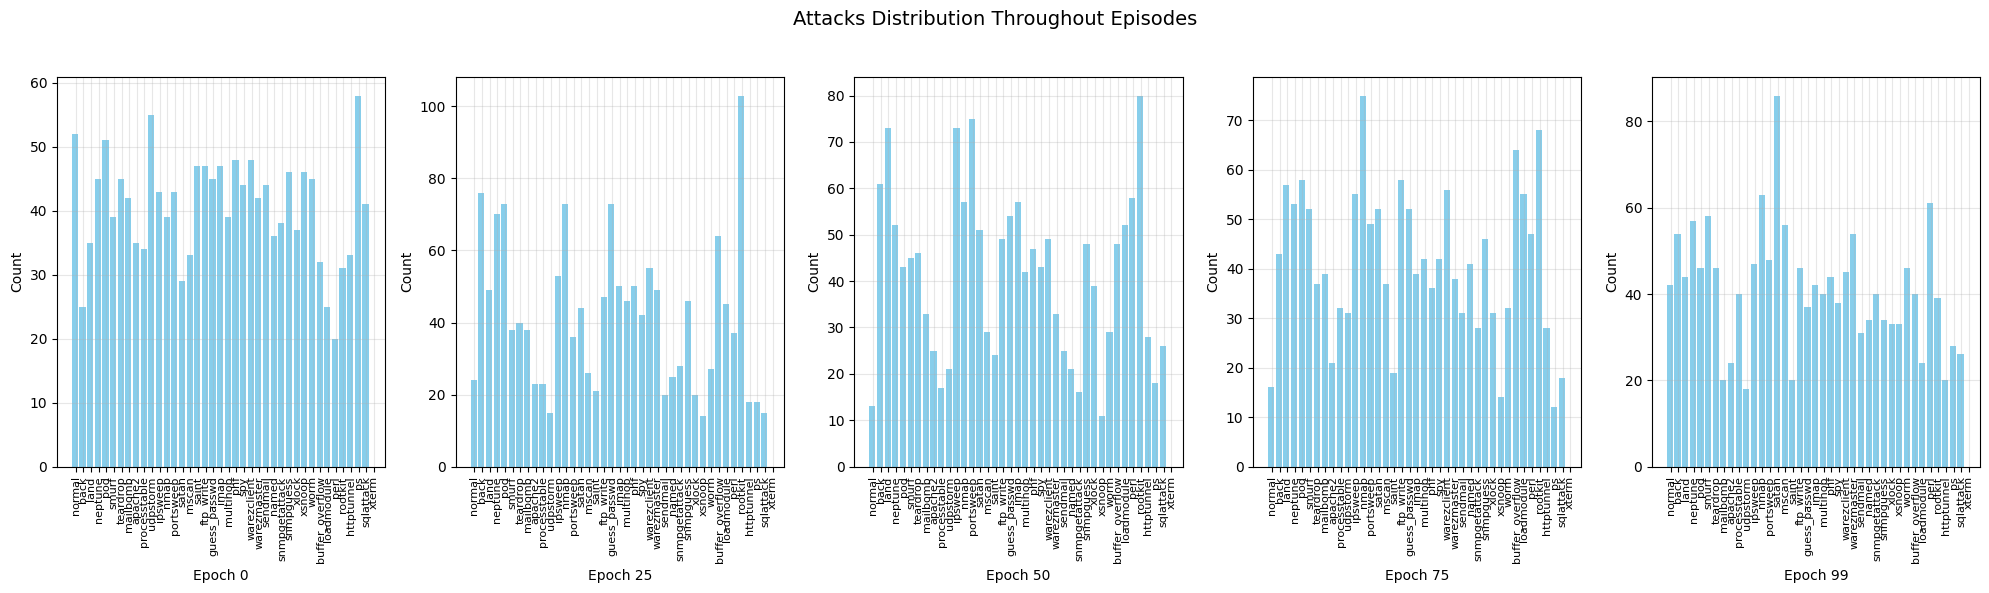

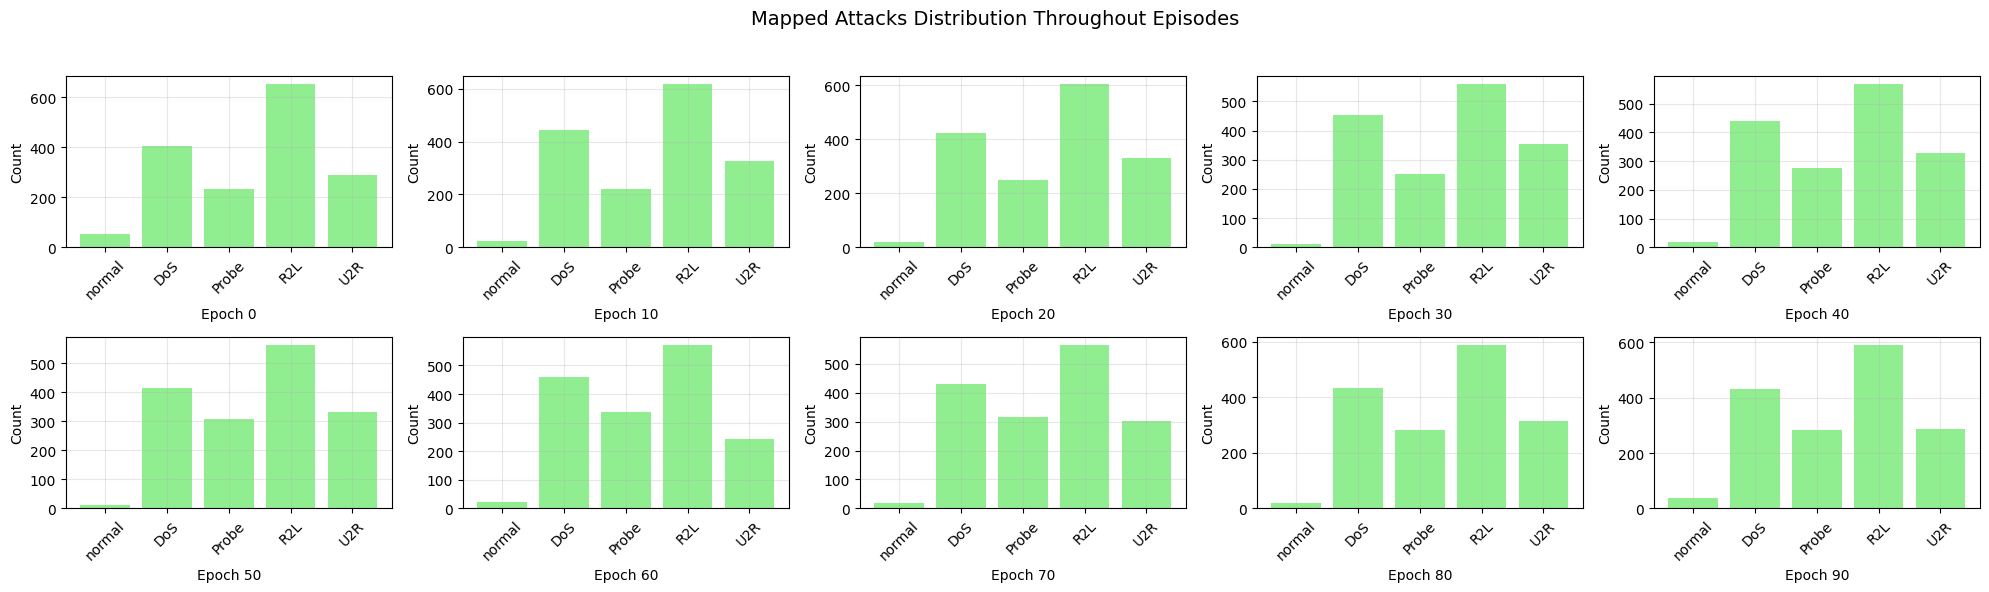

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os


# === Plot Reward and Loss ===
os.makedirs("results", exist_ok=True)
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(def_reward_chain, label='Defense')
plt.plot(att_reward_chain, label='Attack')
plt.title('Total Reward by Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

plt.subplot(212)
plt.plot(def_loss_chain, label='Defense')
plt.plot(att_loss_chain, label='Attack')
plt.title('Loss by Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('results/train_adv.eps', format='eps', dpi=1000)
plt.close()

# === Plot histogram of 23 attack_names ===
bins = np.arange(len(env.attack_names)) - 0.5
plt.figure(figsize=[20, 6])
plt.suptitle("Attacks Distribution Throughout Episodes", fontsize=14)
selected_epochs = [0, 25, 50, 75, len(attacks_by_epoch)-1]
for idx, epoch in enumerate(selected_epochs):
    plt.subplot(1, 5, idx+1)
    plt.hist(attacks_by_epoch[epoch].flatten(), bins=bins, width=0.8, align='mid', color='skyblue')
    plt.xlabel(f"Epoch {epoch}", fontsize=10)
    plt.xticks(range(len(env.attack_names)), env.attack_names, rotation=90, fontsize=8)
    plt.ylabel("Count", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('results/Attacks_distribution.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()
plt.close()

# === Create 5-class mapped attacker counts ===
attack_labels_list = []
for epoch_attacks in attacks_by_epoch:
    sample_mapped = [env.attack_types.index(env.attack_map[env.attack_names[a]]) for a in epoch_attacks.flatten()]
    counts = [sample_mapped.count(i) for i in range(len(env.attack_types))]
    attack_labels_list.append(counts)

# === Plot 5-class attacker distribution across epochs ===
plt.figure(figsize=[20, 6])
plt.suptitle("Mapped Attacks Distribution Throughout Episodes", fontsize=14)
selected_epochs = list(range(0, len(attack_labels_list), 10))
for idx, epoch in enumerate(selected_epochs):
    plt.subplot(2, 5, idx+1)
    plt.bar(range(len(env.attack_types)), attack_labels_list[epoch], tick_label=env.attack_types, color='lightgreen')
    plt.xlabel(f"Epoch {epoch}", fontsize=10)
    plt.xticks(rotation=45, fontsize=10)
    plt.ylabel("Count", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('results/Attacks_mapped_distribution.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()
plt.close()


Test set shape: (22544, 122), labels shape: (22544, 40)
Attack types: ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
Sample mapped indices (true): [3 1 3 0 0 1 1 1 3 0]
Sample predictions: [[4]
 [1]
 [3]
 [3]
 [0]
 [3]
 [1]
 [1]
 [3]
 [0]]

Confusion matrix (counts):
[[6685  841  922  665  598]
 [ 468 5535  256  950  249]
 [ 303  248 1320  443  107]
 [ 229  662   85 1465  313]
 [  33   25   56   20   66]]


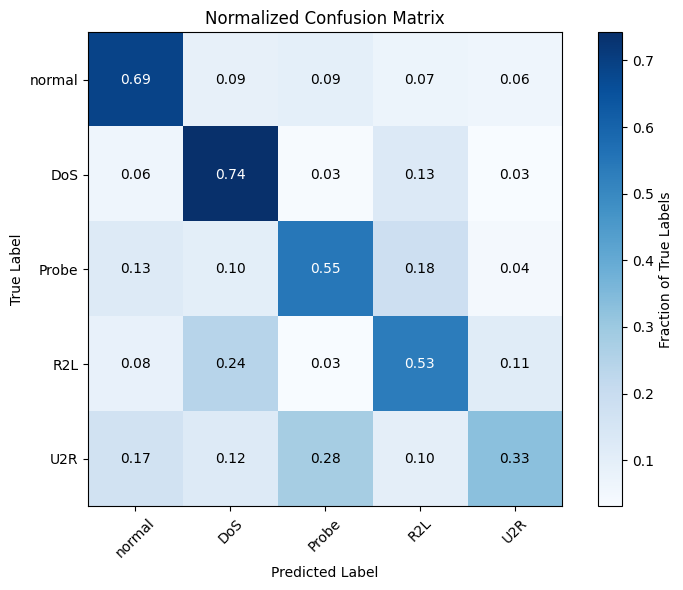


Classification report:
               precision    recall  f1-score   support

      normal     0.8662    0.6884    0.7671      9711
         DoS     0.7571    0.7422    0.7495      7458
       Probe     0.5002    0.5452    0.5217      2421
         R2L     0.4135    0.5320    0.4653      2754
         U2R     0.0495    0.3300    0.0861       200

    accuracy                         0.6685     22544
   macro avg     0.5173    0.5675    0.5180     22544
weighted avg     0.7282    0.6685    0.6920     22544


Custom per-class summary:
       Estimated Correct Total   F1_score
normal      7718    6685  9711  76.711228
DoS         7311    5535  7458  74.954296
Probe       2639    1320  2421  52.173913
R2L         3543    1465  2754  46.530094
U2R         1333      66   200   8.610568

Performance on test data:
Accuracy = 0.6685
F1 = 0.6920
Precision = 0.7282
Recall = 0.6685


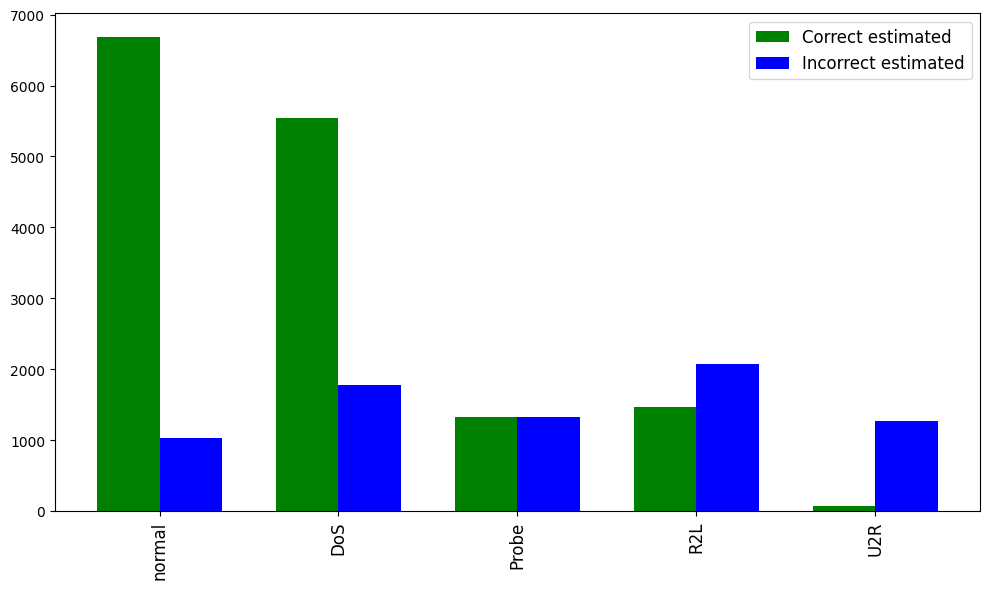


Evaluation complete! Check results/ for visualizations.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score

# ========== TEST/EVALUATION BLOCK ==========

# --- Prepare test environment and reload agent ---
test_env = RLenv('test', train_path=kdd_train, test_path=kdd_test,
                 formated_train_path=formated_train_path, formated_test_path=formated_test_path,
                 batch_size=1, iterations_episode=1)  # batch_size=1 for prediction
test_obs_size = test_env.X.shape[1]
test_defender_agent = Agent(defender_valid_actions, test_obs_size, gamma=0.99, hidden_size=128, hidden_layers=3)
test_defender_agent.load("models/defender")

# --- Load test data ---
states, labels = test_env.get_full()
print(f"Test set shape: {states.shape}, labels shape: {labels.shape}")

# --- Predict with defender agent ---
preds = []
for i in range(len(states)):
    action, *_ = test_defender_agent.act(states[i])
    preds.append(action)
preds = np.array(preds)

# --- Map true labels (one-hot) to attack_type indices ---
maped = []
for i in range(len(labels)):
    attack_name = test_env.attack_names[np.argmax(labels[i])]
    maped.append(test_env.attack_types.index(test_env.attack_map[attack_name]))
maped = np.array(maped)

# --- Sanity Checks ---
print("Attack types:", test_env.attack_types)
print("Sample mapped indices (true):", maped[:10])
print("Sample predictions:", preds[:10])

# --- Confusion Matrix and Per-Class Metrics ---
cm = confusion_matrix(maped, preds)
print("\nConfusion matrix (counts):")
print(cm)

# --- Normalize by true labels (rows) ---
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)

# --- Plot normalized confusion matrix ---
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar(label='Fraction of True Labels')
tick_marks = np.arange(len(test_env.attack_types))
plt.xticks(tick_marks, test_env.attack_types, rotation=45)
plt.yticks(tick_marks, test_env.attack_types)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, f"{cm_normalized[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")
plt.tight_layout()
os.makedirs('results', exist_ok=True)
plt.savefig('results/normalized_confusion_matrix.png', dpi=300)
plt.show()

# --- Per-class report ---
report = classification_report(maped, preds, target_names=test_env.attack_types, digits=4)
print("\nClassification report:\n", report)

# --- Per-class F1 and custom table ---
true_labels = np.bincount(maped, minlength=len(test_env.attack_types))
preds = np.asarray(preds).astype(int).flatten()
estimated_labels = np.bincount(preds, minlength=len(test_env.attack_types))
estimated_correct_labels = np.zeros(len(test_env.attack_types), dtype=int)
for idx, a in enumerate(preds):
    if a == maped[idx]:
        estimated_correct_labels[a] += 1
outputs_df = pd.DataFrame(index=test_env.attack_types, columns=["Estimated", "Correct", "Total", "F1_score"])
for idx, att in enumerate(test_env.attack_types):
    f1 = f1_score(maped == idx, preds == idx)
    outputs_df.loc[att] = [
        estimated_labels[idx], estimated_correct_labels[idx], true_labels[idx], f1 * 100
    ]
print("\nCustom per-class summary:")
print(outputs_df)

# --- Overall metrics ---
print('\nPerformance on test data:')
print('Accuracy = {:.4f}'.format(accuracy_score(maped, preds)))
print('F1 = {:.4f}'.format(f1_score(maped, preds, average="weighted")))
print('Precision = {:.4f}'.format(precision_score(maped, preds, average="weighted")))
print('Recall = {:.4f}'.format(recall_score(maped, preds, average="weighted")))

# --- Bar chart for correct/incorrect estimation ---
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
width = 0.35
pos = np.arange(len(true_labels))
p1 = plt.bar(pos, estimated_correct_labels, width, color='g', label='Correct estimated')
p2 = plt.bar(pos + width, np.abs(estimated_labels - estimated_correct_labels), width, color='b', label='Incorrect estimated')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(test_env.attack_types, rotation='vertical', fontsize='large')
plt.legend(fontsize='large')
plt.tight_layout()
plt.savefig('results/test_adv_summary.png', dpi=300)
plt.show()

print("\nEvaluation complete! Check results/ for visualizations.")

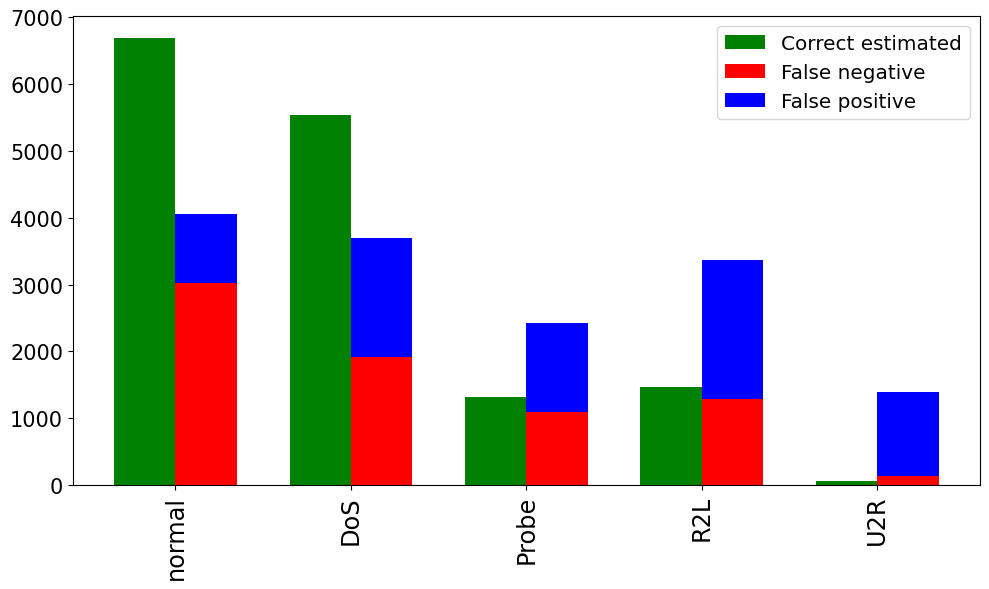

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
width = 0.35
pos = np.arange(len(true_labels))
p1 = plt.bar(pos, estimated_correct_labels,width,color='g')
p1 = plt.bar(pos+width,
             (np.abs(estimated_correct_labels-true_labels)),width,
             color='r')
p2 = plt.bar(pos+width,np.abs(estimated_labels-estimated_correct_labels),width,
             bottom=(np.abs(estimated_correct_labels-true_labels)),
             color='b')

ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticks(pos+width/2)
ax.set_xticklabels(env.attack_types,rotation='vertical',fontsize = 'xx-large')

#ax.set_yscale('log')

#ax.set_ylim([0, 100])
#ax.set_title('Test set scores',fontsize = 'xx-large')
#ax.set_title('Test set scores, Acc = {:.2f}'.format(acc))
plt.legend(('Correct estimated','False negative','False positive'),fontsize = 'x-large')
plt.tight_layout()
#plt.show()
plt.savefig('results/test_adv_imp.svg', format='svg', dpi=1000)


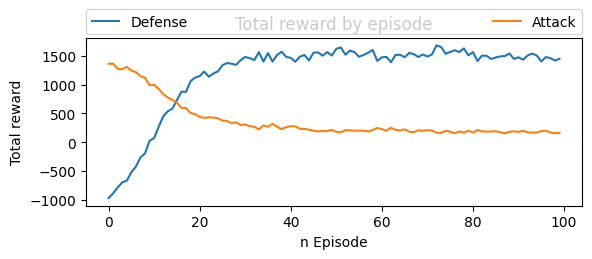

In [26]:
# =================== PLOT TRAINING RESULTS =================== 
# Plot training results
plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(len(def_reward_chain)),def_reward_chain,label='Defense')
plt.plot(np.arange(len(att_reward_chain)),att_reward_chain,label='Attack')
plt.title('Total reward by episode')
plt.xlabel('n Episode')
plt.ylabel('Total reward')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
